In [2]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
# plt.rcParams['figure.figsize'] = 10, 10

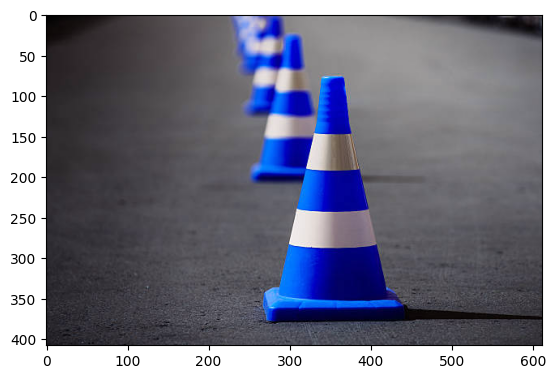

In [3]:
img = cv2.imread("traffic_cone_image/cone.jpg")
plt.imshow(img)
plt.show()

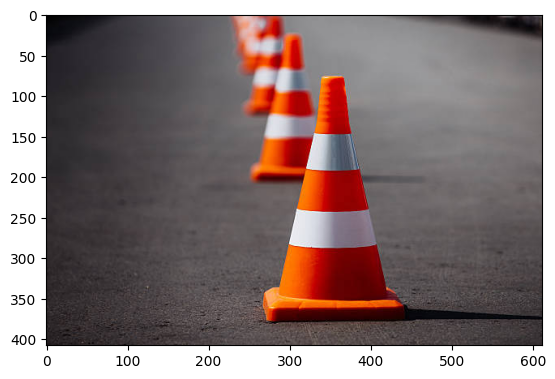

In [4]:
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()

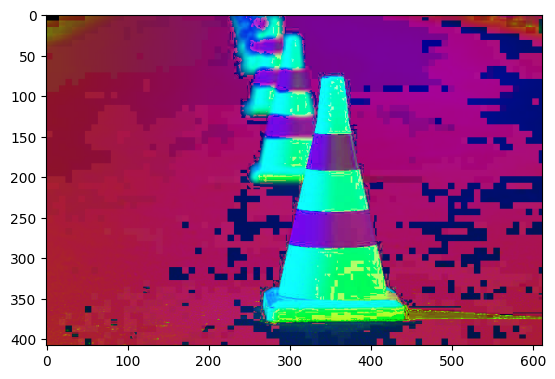

In [5]:
img_HSV = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
plt.imshow(img_HSV)
plt.show()

In [6]:
img_thresh_low = cv2.inRange(img_HSV, np.array([0, 135, 135]), np.array([15, 255, 255]))
img_thresh_high = cv2.inRange(img_HSV, np.array([159, 135, 135]), np.array([179, 255, 255]))
img_thresh = cv2.bitwise_or(img_thresh_low, img_thresh_high)

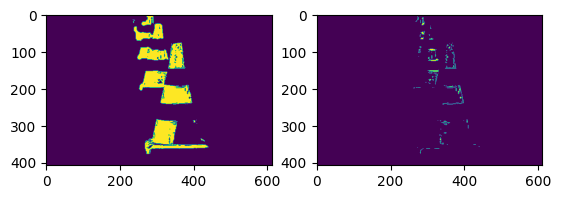

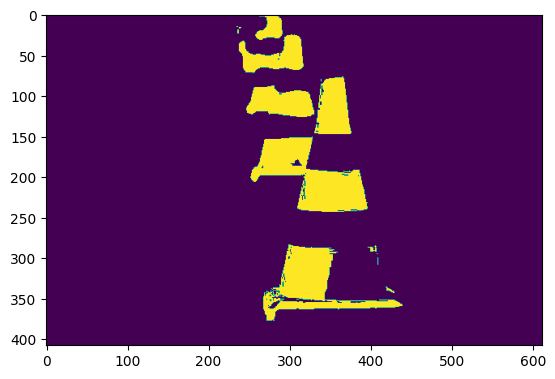

In [7]:
f, axarr = plt.subplots(nrows=1, ncols=2)
axarr[0].imshow(img_thresh_low)
axarr[1].imshow(img_thresh_high)
plt.show()

plt.imshow(img_thresh)
plt.show()

In [8]:
kernel = np.ones((5, 5))
img_thresh_opened = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel)

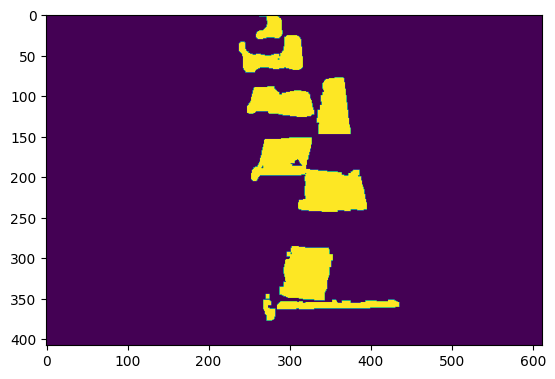

In [9]:
plt.imshow(img_thresh_opened)
plt.show()

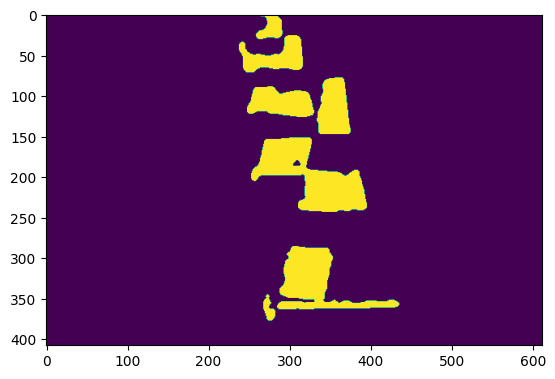

In [10]:
img_thresh_blurred = cv2.medianBlur(img_thresh_opened, 5)
plt.imshow(img_thresh_blurred)
plt.show()

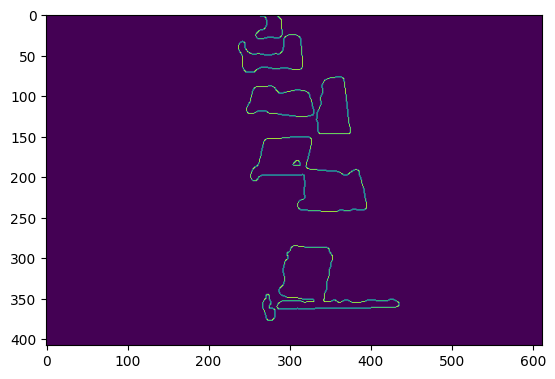

In [11]:
img_edges = cv2.Canny(img_thresh_blurred, 80, 160)
plt.imshow(img_edges)
plt.show()

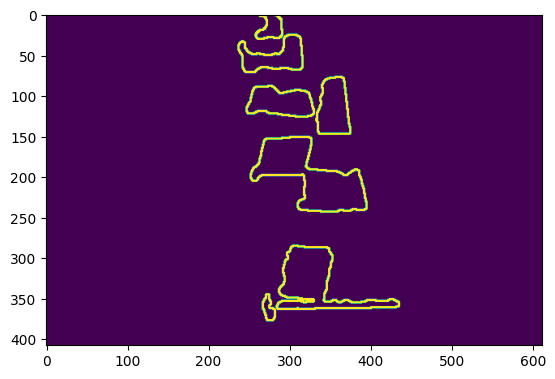

In [12]:
contours, hierarchy = cv2.findContours(np.array(img_edges), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.zeros_like(img_edges)
cv2.drawContours(img_contours, contours, -1, (255,255,255), 2)
plt.imshow(img_contours)
plt.show()

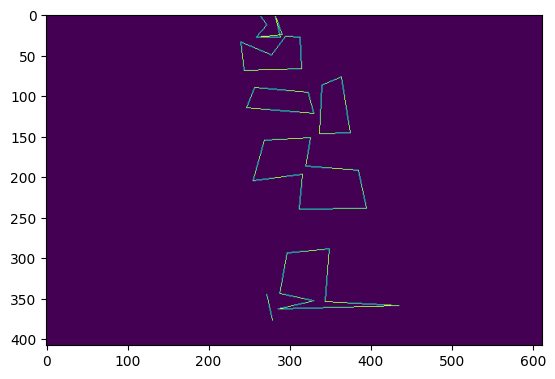

In [13]:
approx_contours = []

for c in contours:
    approx = cv2.approxPolyDP(c, 10, closed = True)
    approx_contours.append(approx)
img_approx_contours = np.zeros_like(img_edges)
cv2.drawContours(img_approx_contours, approx_contours, -1, (255,255,255), 1)
plt.imshow(img_approx_contours)
plt.show()

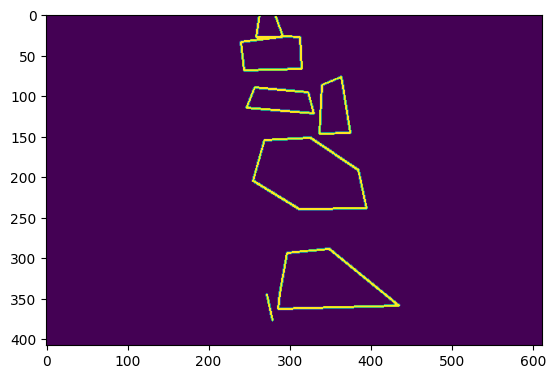

In [14]:
all_convex_hulls = []
for ac in approx_contours:
    all_convex_hulls.append(cv2.convexHull(ac))
img_all_convex_hulls = np.zeros_like(img_edges)
cv2.drawContours(img_all_convex_hulls, all_convex_hulls, -1, (255,255,255), 2)
plt.imshow(img_all_convex_hulls)
plt.show()

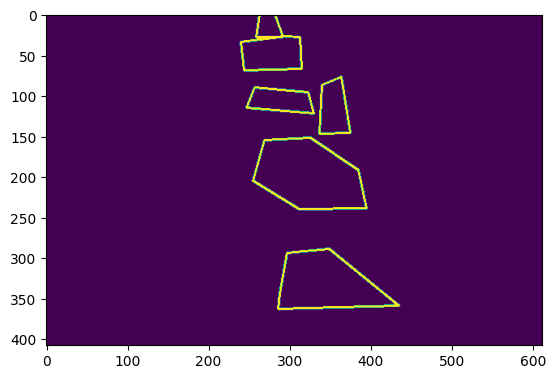

In [15]:
convex_hulls_3to10 = []
for ch in all_convex_hulls:
    if 3 <= len(ch) <= 10:
        convex_hulls_3to10.append(cv2.convexHull(ch))
img_convex_hulls_3to10 = np.zeros_like(img_edges)
cv2.drawContours(img_convex_hulls_3to10, convex_hulls_3to10, -1, (255,255,255), 2)
plt.imshow(img_convex_hulls_3to10)
plt.show()

In [16]:
def convex_hull_pointing_up(ch):
    points_above_center, points_below_center = [], []
    
    x, y, w, h = cv2.boundingRect(ch)
    aspect_ratio = w / h
    if aspect_ratio < 0.8:
        vertical_center = y + h / 2

        for point in ch:
            if point[0][1] < vertical_center:
                points_above_center.append(point)
            elif point[0][1] >= vertical_center:
                points_below_center.append(point)

        left_x = points_below_center[0][0][0]
        right_x = points_below_center[0][0][0]
        for point in points_below_center:
            if point[0][0] < left_x:
                left_x = point[0][0]
            if point[0][0] > right_x:
                right_x = point[0][0]
        for point in points_above_center:
            if (point[0][0] < left_x) or (point[0][0] > right_x):
                return False
    else:
        return False
        
    return True

In [17]:
cones = []
bounding_rects = []
for ch in convex_hulls_3to10:
    if convex_hull_pointing_up(ch):
        cones.append(ch)
        rect = cv2.boundingRect(ch)
        bounding_rects.append(rect)

Traffic Cone is detected, Car is slowing down!


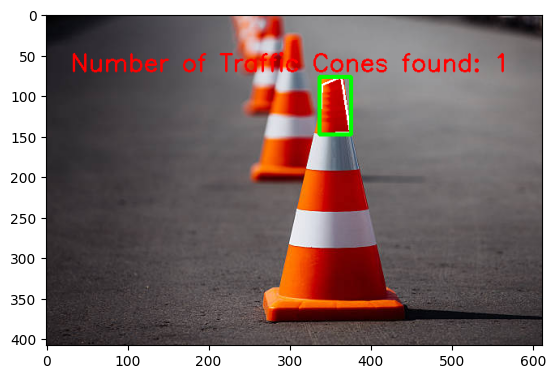

In [18]:
img_res = img.copy()
cv2.drawContours(img_res, cones, -1, (255,255,255), 2)

count = len(bounding_rects)
for rect in bounding_rects:
    cv2.rectangle(img_res, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (1, 255, 1), 3)

# Add text to image
text = "Number of Traffic Cones found: " + str(count)
cv2.putText(img_res, text, (30,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

if count >= 1:
    print("Traffic Cone is detected, Car is slowing down!")

plt.imshow(cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB))
plt.show()
